# PMOIRED example #3: AX Cir and companion search

binary search *à la* [CANDID](https://github.com/amerand/CANDID). Results are currently slightly different from CANDID, as bandwidth smearing in PMOIRED is still not computed properly, and in the case of AX Cir, the separation is quite large compared to to the bandwidth semaring radius (R$\lambda$/B).  

In this example:
- model the observations with a simple gray binary 
- using `gridFit` and `showGrid` to find the global minimum for the sepration vector of the binary
- bootstrapping to better estimate the object's parameters
- usinf `detectionLimit` to estimate detection limit on a third companion

*https://github.com/amerand/PMOIRED - Antoine Mérand (amerand@eso.org)*

In [1]:
%pylab notebook
try:
    # -- global installation
    import pmoired
    print('global')
except:
    # -- local installation
    import sys
    sys.path = ['../pmoired'] + sys.path
    import __init__ as pmoired
    print('local')
import os

from importlib import reload

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

Populating the interactive namespace from numpy and matplotlib
[P]arametric [M]odeling of [O]ptical [I]nte[r]ferom[e]tric [D]ata https://github.com/amerand/PMOIRED
local


# Load Data

In [2]:
oi = pmoired.OI('./AXCir/AXCir.oifits')

loadOI: loading ./AXCir/AXCir.oifits
  > insname: "PIONIER_Pnat(1.6135391/1.7698610)" targname: "AX_CIR" pipeline: ""
  > MJD: (500,) [ 56487.97305633923 .. 56488.06321311114 ]
  > D0-G1-H0-I1 | WL: (3,) [ 1.614 .. 1.77 ] um (R~18) {'OI_T3': 4, 'OI_VIS2': 6} | | TELLURICS: False


# Grid Search
To do a grid search, we need to define:
- a basic model, here composed of a primary star `*` and a a companion `c`. The 
- an exploration dictionnary `expl`: here we want to do explore `c,x` and `c,y` in a grid, each between -40 and +40mas (R$_{spectro}$ <$\lambda$>/B$_{max}$/2), with a step of 4mas (<$\lambda$>/B$_{max}$).    
- as usual, which observable we will fit: `V2` and `T3PHI`

It is important to let `gridFit()` which parameters to fit. As usual, one needs to fix one of the fluxes, here the flux of the primary star. We also assume that the companion is unresolved, so its angular diameter is fixed to 0. Searching beyond R$_{spectro}$ <$\lambda$>/B$_{max}$/2, the effects of bandwidth smearing start to be quite important and will reduce the interferometric signal of the binary. Since `PMOIRED` does not compute (yet) correctly the bandwidth smearing, the contrast ratio will be incorrect for large separation, which is the case for AX Cir.   

In [3]:
# -- smallest lambda/B in mas (first data set) 
step = 180*3600*1000e-6/np.pi/max([np.max(oi.data[0]['OI_VIS2'][k]['B/wl']) for k in oi.data[0]['OI_VIS2']])

# -- spectral resolution (first data set) 
R = np.mean(oi.data[0]['WL']/oi.data[0]['dWL'])

print('step: %.1fmas, range: +- %.1fmas'%(step, R/2*step))

# -- initial model dict: 'c,x' and 'c,y' do not matter, as they will be explored in the fit
param = {'*,ud':0.8, '*,f':1, 'c,f':0.01, 'c,x':0, 'c,y':0, 'c,ud':0.0}

# -- define the exploration pattern
expl = {'grid':{'c,x':(-R/2*step, R/2*step, step), 'c,y':(-R/2*step, R/2*step, step)}}

# -- setup the fit, as usual
oi.setupFit({'obs':['V2', 'T3PHI']})

# -- actual grid fit
oi.gridFit(expl, model=param, doNotFit=['*,f', 'c,ud'])

step: 4.0mas, range: +- 36.6mas
Tue Jun 15 21:31:12 2021: running 361 fits on 8 processes
  one fit takes ~0.54s [~110.8 fit/minute]
Tue Jun 15 21:31:16 2021: approx 3.2min remaining
Tue Jun 15 21:31:57 2021: it took 45.7s, 0.13s per fit on average [473.7 fit/minutes]
fit converged: 361 / 361
unique minima: 169 / 361
------------
best fit: chi2= 0.7334123223824371
{'*,ud':0.8278, # +/- 0.0078
'c,f': 0.00853, # +/- 0.00039
'c,x': 6.226, # +/- 0.059
'c,y': -28.503, # +/- 0.078
'*,f': 1,
'c,ud':0.0,
}

Correlations (%)  >=90 >=80 >=70 >=50 >=20 <20%
         0   1   2   3  
 0:*,ud ### -64  -1   6 
 1: c,f -64 ###   1 -14 
 2: c,x  -1   1 ###  15 
 3: c,y   6 -14  15 ### 


# Inspect grid search

`showGrid()` shows a 2D map of the $\chi^2$ of the minima. The black crosses are the starting points of the fits, and the coloured dots are the location / corresponding $\chi^2$ of the local minima.

<IPython.core.display.Javascript object>


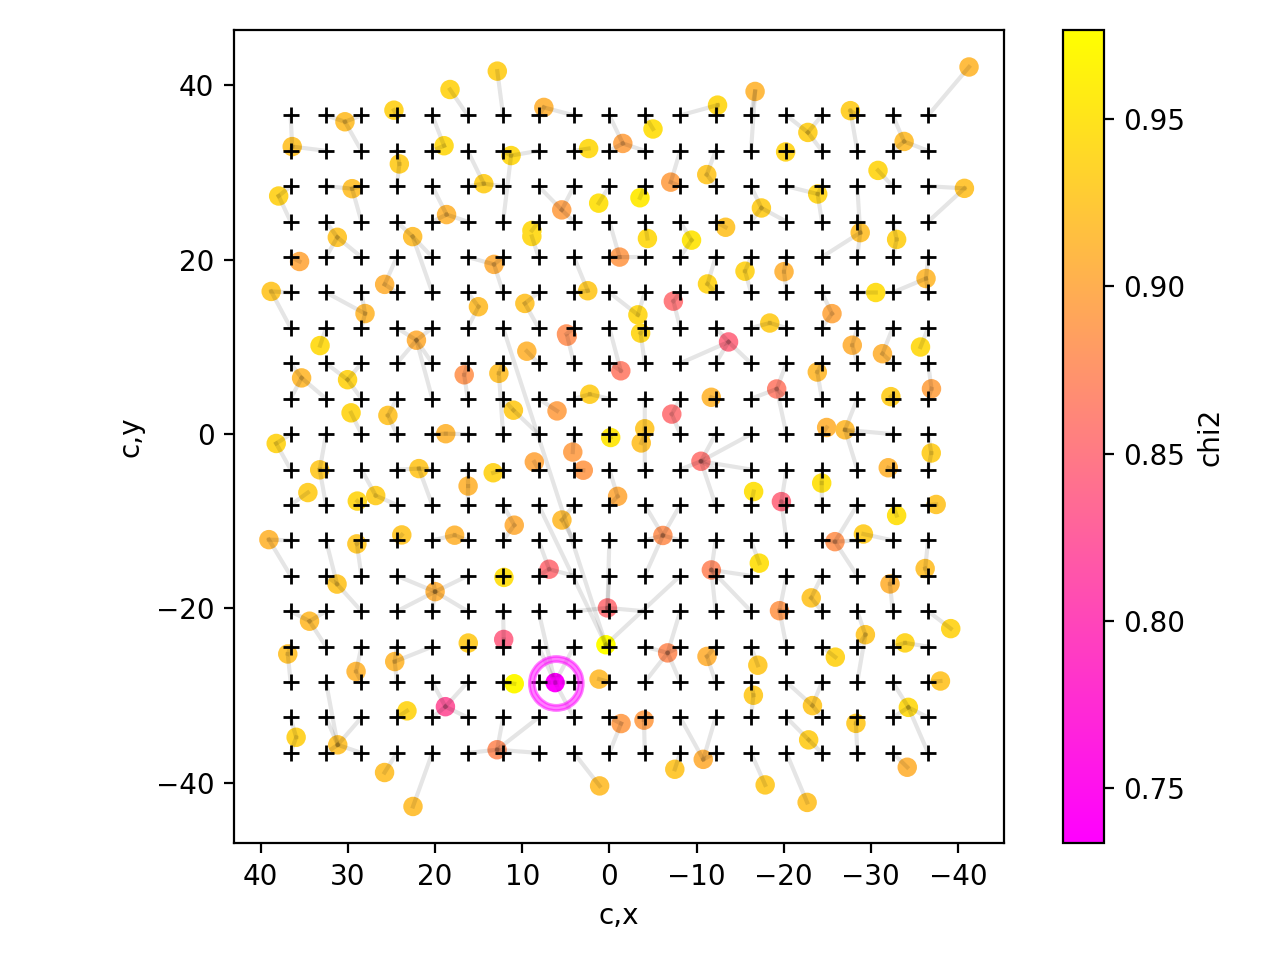

In [4]:
# -- show the 2D grid of reduced chi2
oi.showGrid()

# Show best fit model and fit to the data

<IPython.core.display.Javascript object>


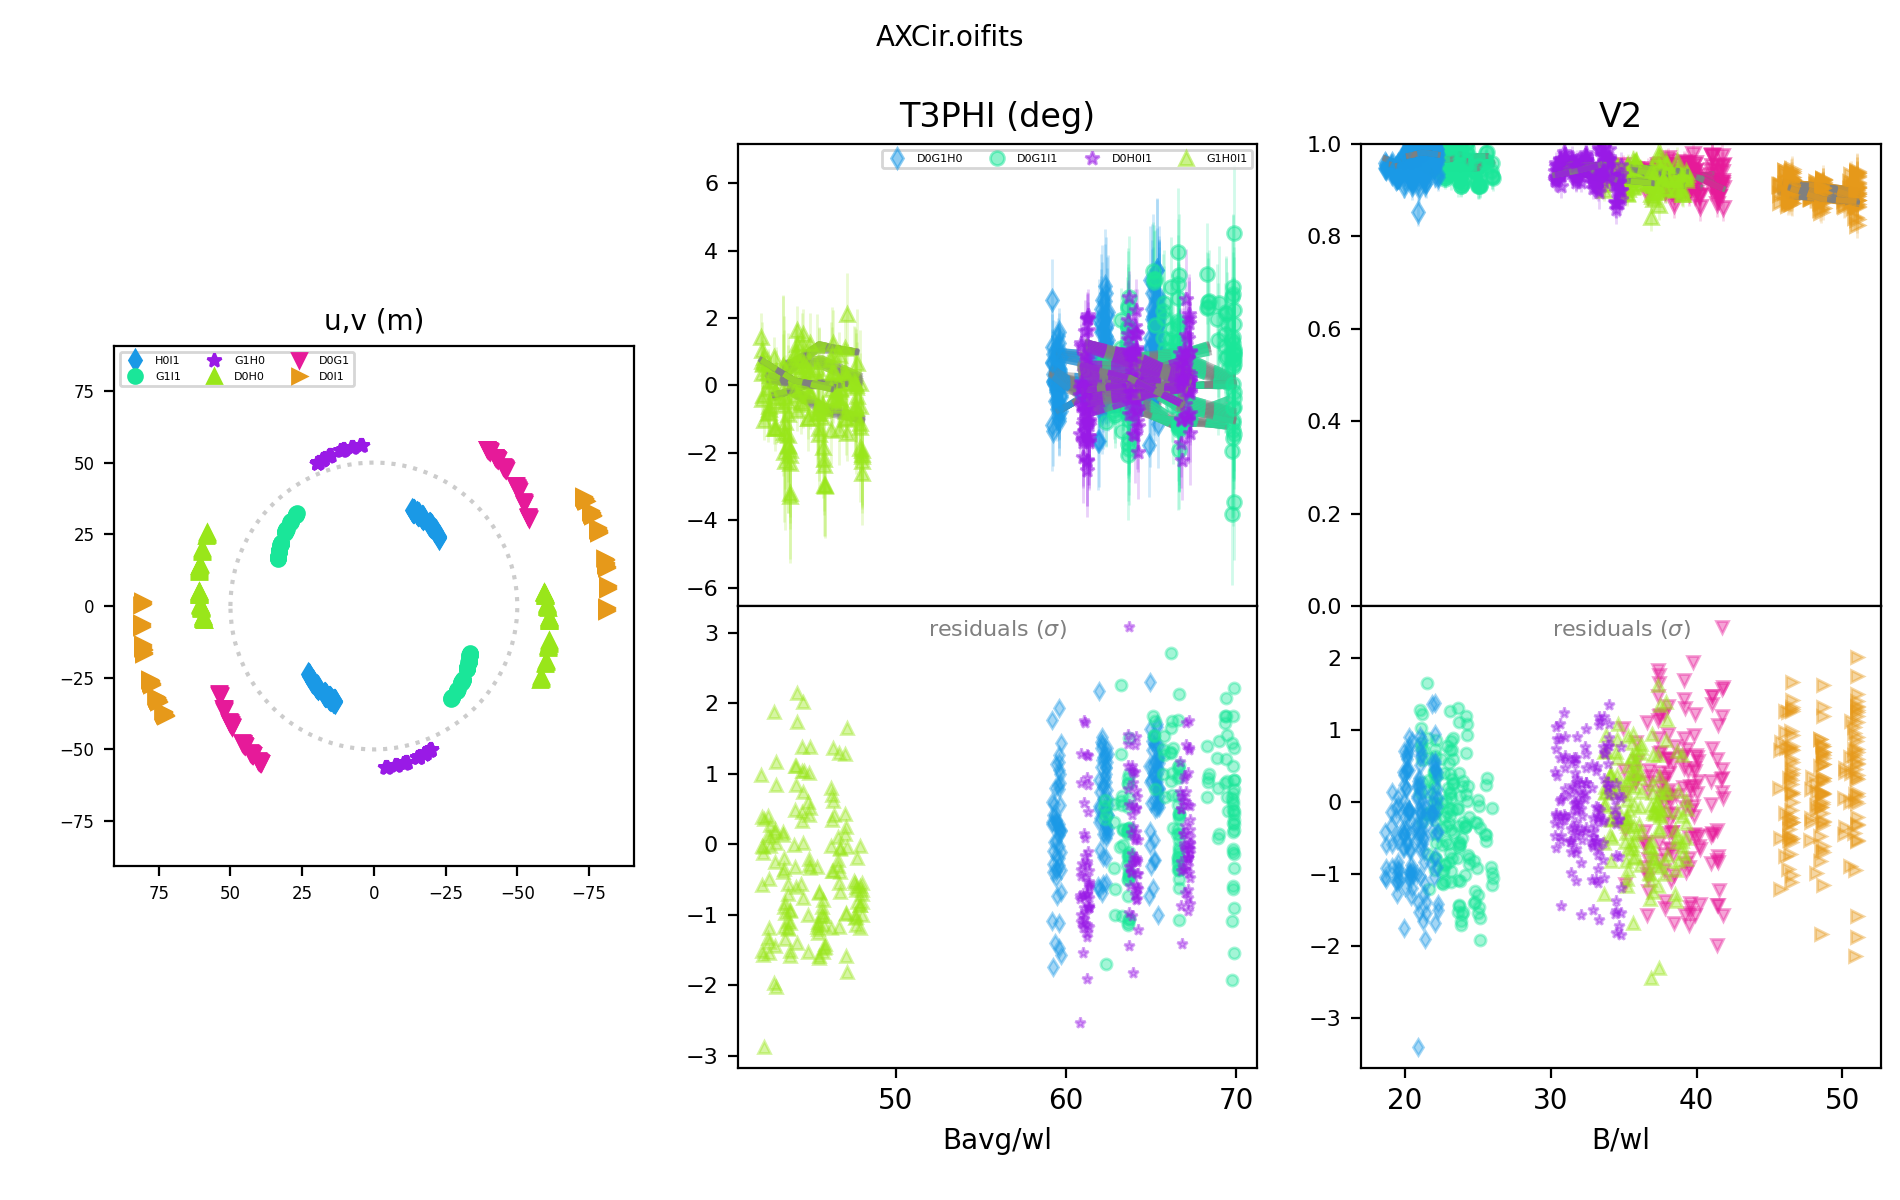

In [5]:
# -- show data with best fit 
oi.show()

# Parameters estimation using bootstrapping
One can refine the estimation of the companion's parameters, by using bootstrapping. This usually results in larger uncertainties, because bootstrapping mitigate the effects of correlated data. In the case of this example, because we have only one sequence of observations, data resampling does not help much. However, it shows that the data set is consistent: there are no part of the dataset improving / degrading the companion detection.

Tue Jun 15 21:32:01 2021: running 100 fits on 8 processes
  one fit takes ~0.38s [~158.5 fit/minutes]
Tue Jun 15 21:32:04 2021: approx 34.8s remaining
Tue Jun 15 21:32:11 2021: it took 9.2s, 0.09s per fit on average [650.8 fit/minutes]
using 100 fits out of 100 (sigma clipping 4.50)
{'*,f' :1
'*,ud': 0.8284, # +/- 0.0076
'c,f' : 0.00854, # +/- 0.00039
'c,ud':0.0
'c,x' : 6.227, # +/- 0.061
'c,y' : -28.503, # +/- 0.069
}
Correlations (%)  >=90 >=80 >=70 >=50 >=20 <20%
         0   1   2   3  
 0:*,ud ### -72 -30   7  -6 
 1: c,f -72 ###  22 -17  14 
 2: c,x -30  22 ###  -5 -22 
 3: c,y   7 -17  -5 ###  10 


<IPython.core.display.Javascript object>


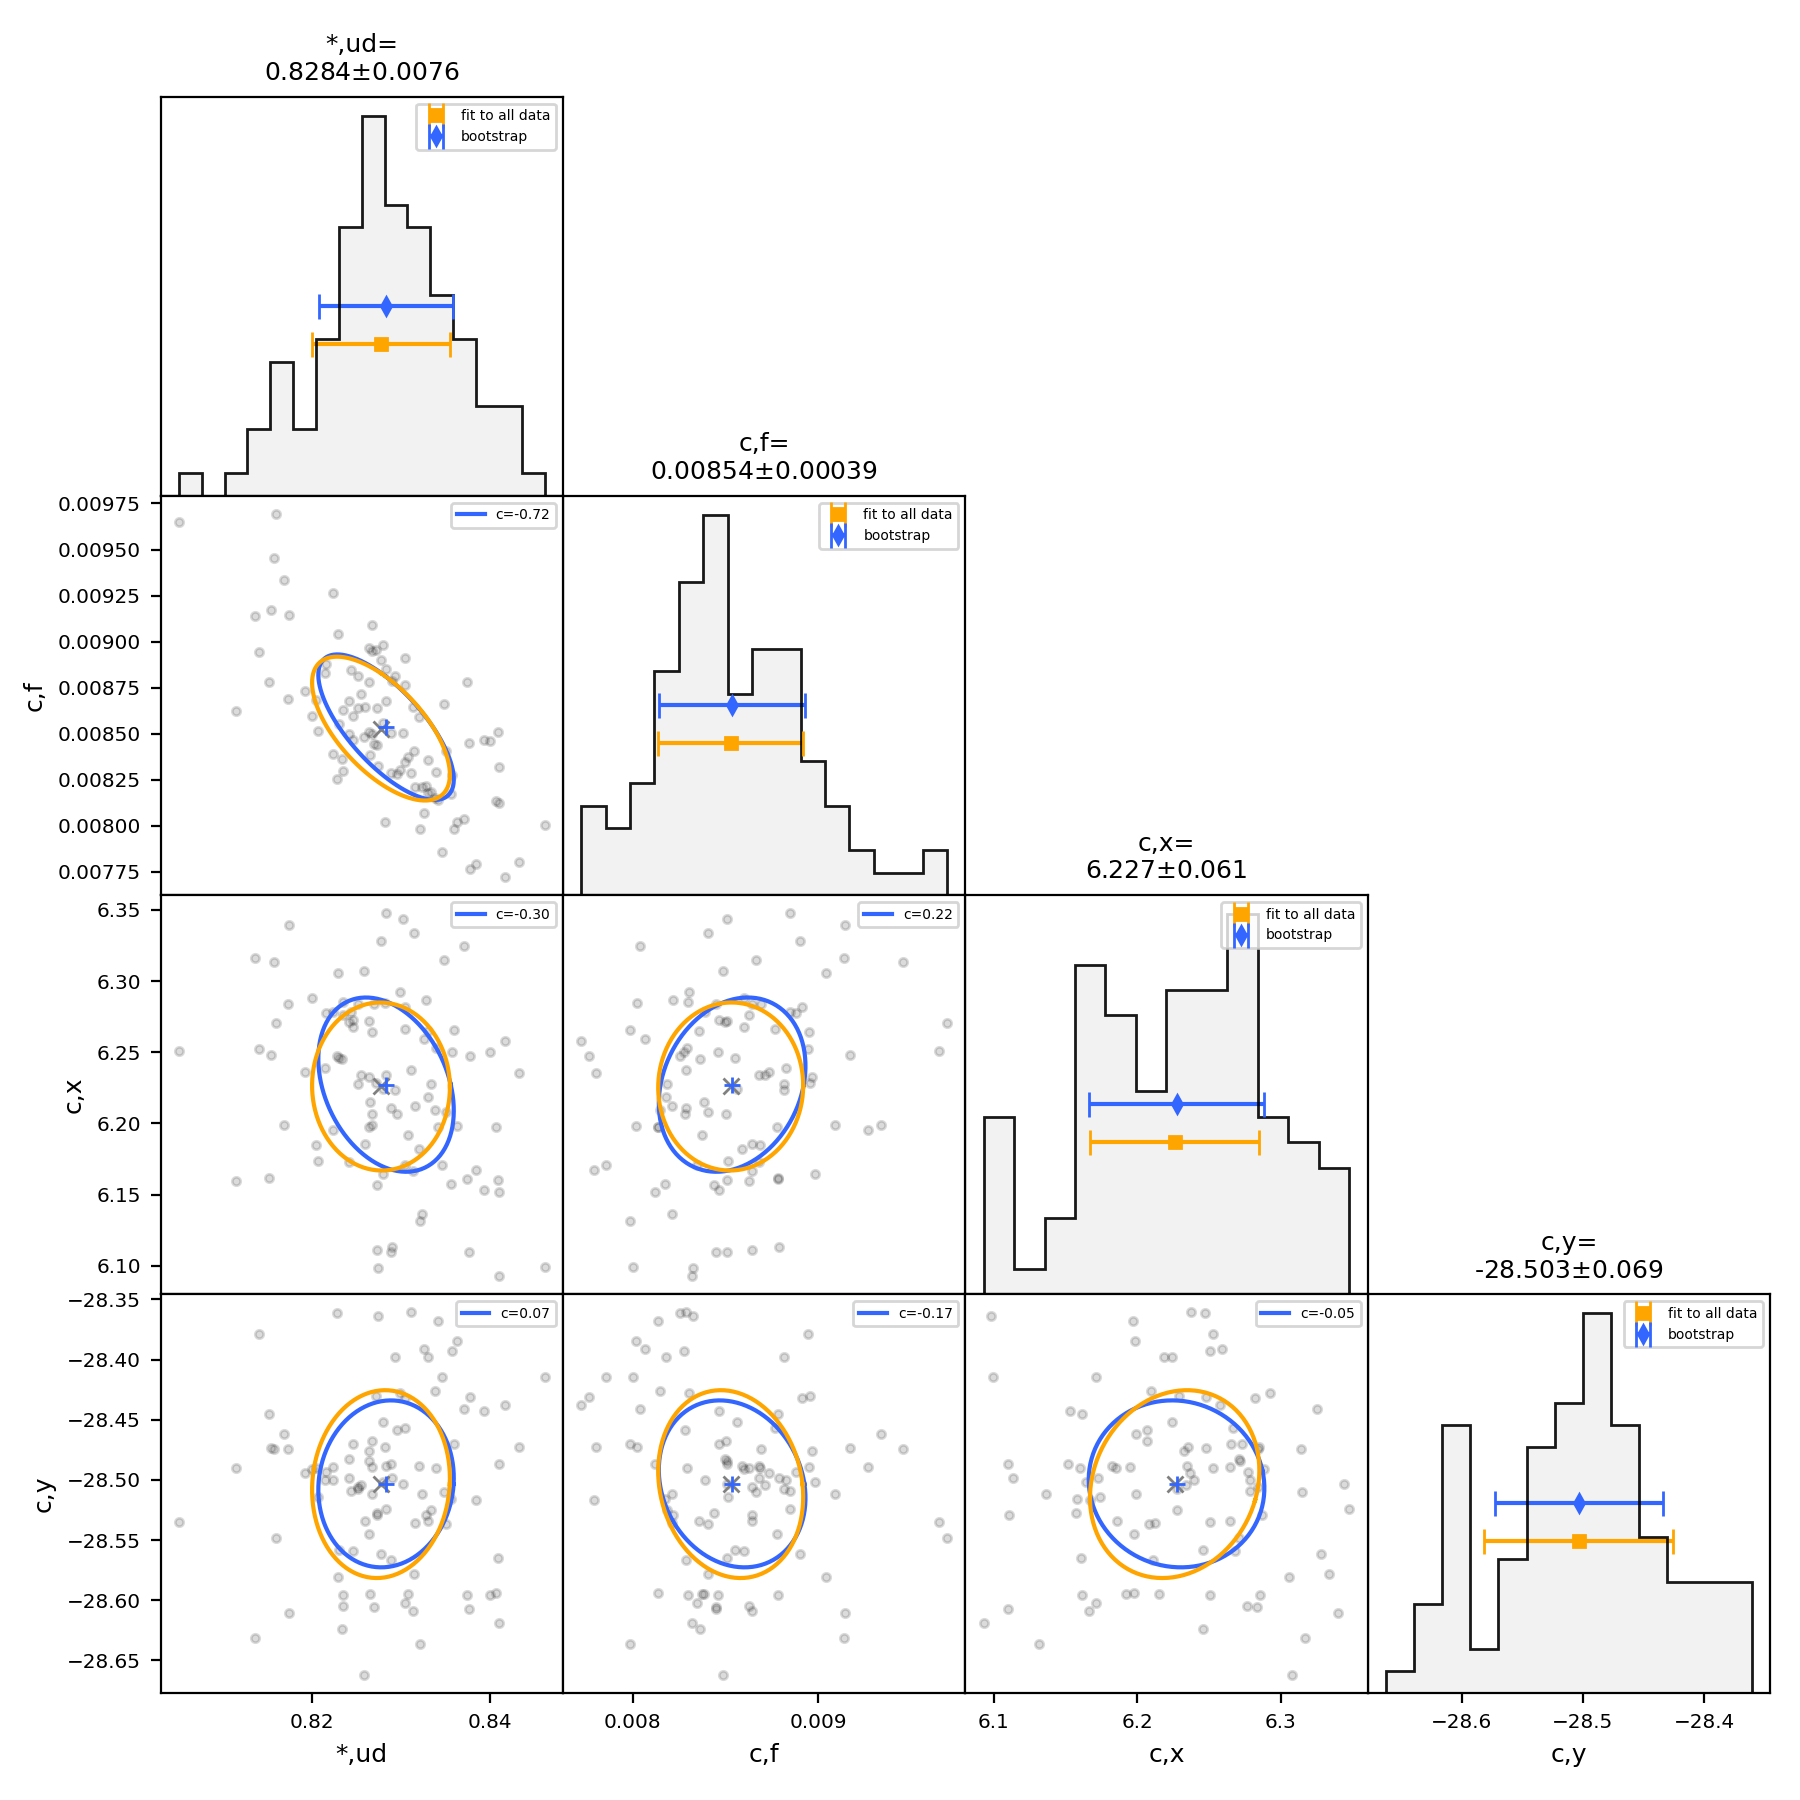

ellipse (emin, emax, PA) for c,x/c,y: 0.0609 0.0697 -10.9


In [6]:
oi.bootstrapFit(100)
oi.showBootstrap()

# Look for a third component: detection limit

Assuming that the best model is the one we found before, we add a third unresolved component. Using `detectionLimit` in a way very similar to `gridSearch`. We define an expolration pattern randomisinz on the position of the third components, and estimating the flux leading to a 3$\sigma$ detection. This method was described in [Absil et al (2011)](https://ui.adsabs.harvard.edu/abs/2011A%26A...535A..68A/abstract) and implemented in [CANDID](https://github.com/amerand/CANDID). Using `showLimGrid`, we see the detection level as function of position of third component (left), as well as the histogram of the its 3$\sigma$ magnitude. Note that we need to set `mag=1` option to get the display in magnitude, rather than straight fluxes. Note also that interpretating the result need to take into account the flux of the primary, which is 1 in our case.  

CANDID finds a $\sim$5.6mag detecion limit for 99% of the position. Here, the median third star has a detection limit of 6.0mag, and 95% are between 5.7 and 6.3mag. 

Tue Jun 15 21:32:12 2021: running 500 fits on 8 processes
  one fit takes ~0.38s [~157.6 fit/minute]
Tue Jun 15 21:32:15 2021: approx 3.1min remaining
Tue Jun 15 21:32:26 2021: it took 14.0s, 0.03s per fit on average [2143.5 fit/minutes]


<IPython.core.display.Javascript object>


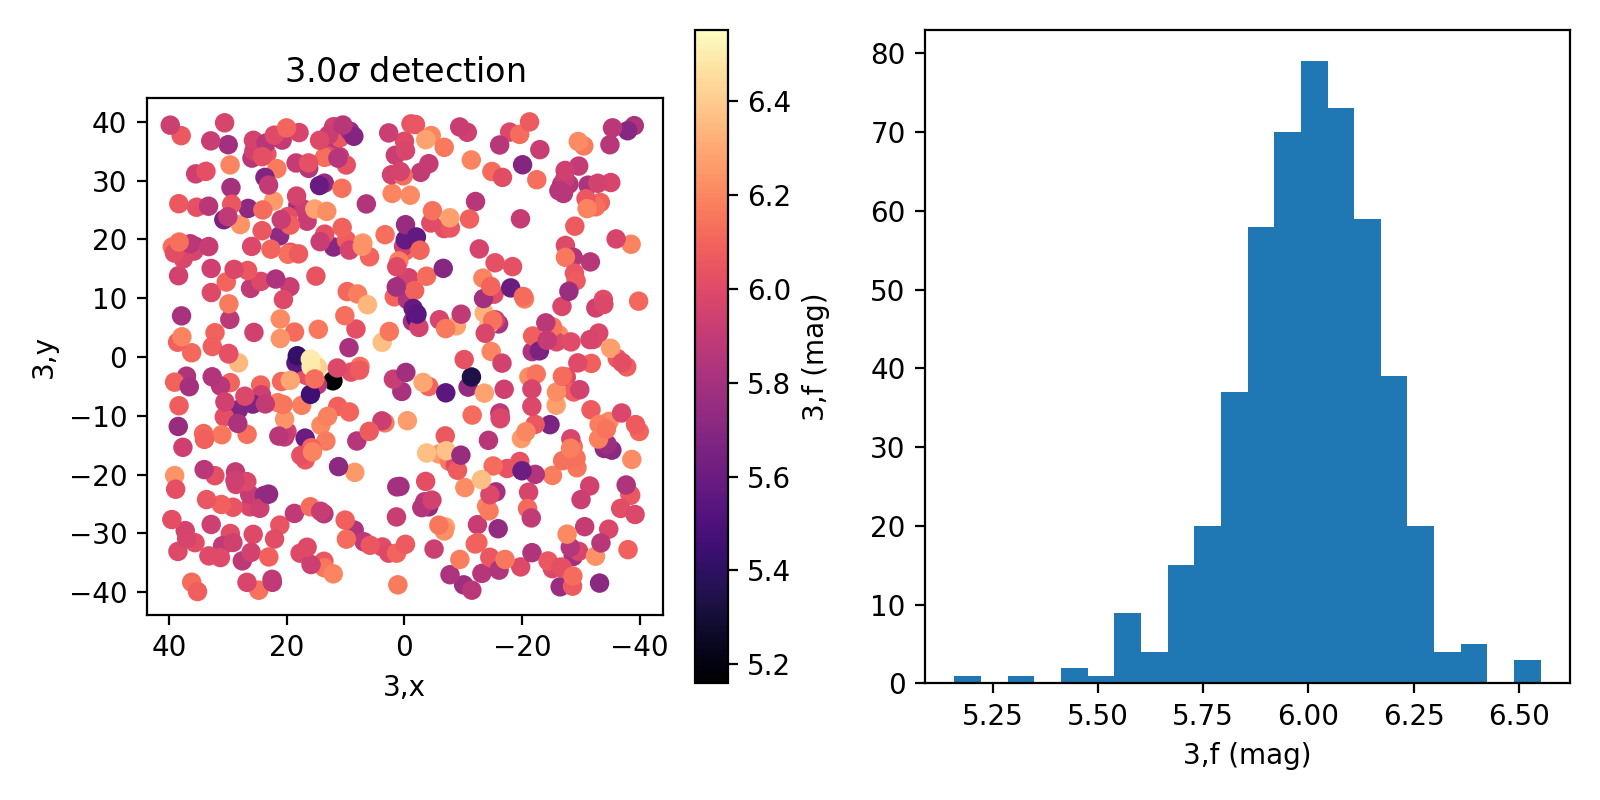

median 3,f : 5.9995136574780625  (mag)
1sigma (68%) 5.846176503436722 -> 6.161199690305397
2sigma (95%) 5.596768448435432 -> 6.290695503869833


In [7]:
# -- best model from above
best = {'*,ud':0.8278, # +/- 0.0078
        'c,f': 0.00853, # +/- 0.00039
        'c,x': 6.226, # +/- 0.059
        'c,y': -28.503, # +/- 0.078
        '*,f': 1,
        'c,ud':0.0,
        '3,ud':0, '3,x':-15, '3,y':5, '3,f':0.01
       }

# -- grid exploration
#expl = {'grid':{'3,x':(-20, 20, 1), '3,y':(-20, 20, 1)}}
#oi.detectionLimit(expl, '3,f', model=best)

# -- random exploration
expl = {'rand':{'3,x':(-40, 40), '3,y':(-40, 40)}}
oi.detectionLimit(expl, '3,f', model=best, Nfits=500, nsigma=3)
 
oi.showLimGrid(mag=1)